In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import warnings
warnings.filterwarnings("ignore")

fyi : By calling tf.config.run_functions_eagerly(True), you are setting the global TensorFlow configuration to enable eager execution mode. Once enabled, TensorFlow will execute operations immediately as they are called, without building a computational graph. This can be useful for quick prototyping, small-scale experiments, or when you need to access intermediate results during computation.


In [3]:
fpath = r"C:\Users\Gamer\Downloads\Filtered"
img_size = 224
batch_size =32
train = tf.keras.utils.image_dataset_from_directory(
  fpath,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_size, img_size),
  batch_size=batch_size,
  label_mode ="categorical"
)

Found 250 files belonging to 5 classes.
Using 200 files for training.


fyi:When label_mode is set to 'Categorical', it means that the labels are represented in a categorical or one-hot encoded format. In a categorical encoding scheme, each label is transformed into a binary vector where only one element is set to 1, representing the class to which the sample belongs, and all other elements are set to 0.

For example, let's consider a classification problem with three classes: A, B, and C. In the categorical encoding scheme, the labels for each class would be represented as follows:

Class A: [1, 0, 0]
Class B: [0, 1, 0]
Class C: [0, 0, 1]

In [4]:
fpath_val=r"C:\Users\Gamer\Downloads\Filtered"
val = tf.keras.utils.image_dataset_from_directory(
  fpath_val,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_size, img_size),
  batch_size=batch_size,
  label_mode ="categorical"
)

Found 250 files belonging to 5 classes.
Using 50 files for validation.


In [5]:
class_names = train.class_names
print(class_names)


['akshay_kumar', 'amitabh_bachchan', 'salman_khan', 'shah_rukh_khan', 'vidya_balan']


In [6]:
Model_URL ='https://kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-classification/versions/2'


# fyi: ResNet V2 50, or ResNet-50, is a convolutional neural network (CNN) architecture that belongs to the ResNet (Residual Network) family of models. ResNet-50 was introduced by Microsoft Research in 2015 and has been widely adopted and recognized for its excellent performance in image classification tasks.

In [7]:
model = Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(img_size, img_size, 3)),
    hub.KerasLayer(Model_URL),
    tf.keras.layers.Dense(5, activation="softmax")])

fyi:The softmax function is commonly used for multi-class classification tasks. It transforms the output of each neuron into a probability distribution across the different classes. The output values will be between 0 and 1 and sum up to 1, representing the probabilities of the input belonging to each class.

In [8]:
model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

In [9]:
model.build((img_size, img_size, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1001)              25615849  
                                                                 
 dense (Dense)               (None, 5)                 5010      
                                                                 
Total params: 25,620,859
Trainable params: 5,010
Non-trainable params: 25,615,849
_________________________________________________________________


In [10]:
model_name= "model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)



earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5,
                                                 verbose = 1, restore_best_weights=True)

reduce_lr = tf._keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [11]:
history= model.fit(train, epochs=30, validation_data=val, callbacks=[checkpoint,earlystopping, reduce_lr])

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 2.3597 - accuracy: 0.2700 
Epoch 1: val_loss improved from inf to 1.52237, saving model to model.h5
7/7 [==============================] - 282s 32s/step - loss: 2.3597 - accuracy: 0.2700 - val_loss: 1.5224 - val_accuracy: 0.4400 - lr: 0.0010
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 1.4502 - accuracy: 0.4700 
Epoch 2: val_loss improved from 1.52237 to 0.92123, saving model to model.h5
7/7 [==============================] - 202s 27s/step - loss: 1.4502 - accuracy: 0.4700 - val_loss: 0.9212 - val_accuracy: 0.7200 - lr: 0.0010
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 0.9947 - accuracy: 0.6100 
Epoch 3: val_loss improved from 0.92123 to 0.91418, saving model to model.h5
7/7 [==============================] - 176s 24s/step - loss: 0.9947 - accuracy: 0.6100 - val_loss: 0.9142 - val_accuracy: 0.6600 - lr: 0.0010
Epoch 4/30
7/7 [==============================] - ETA: 0s - loss: 0.

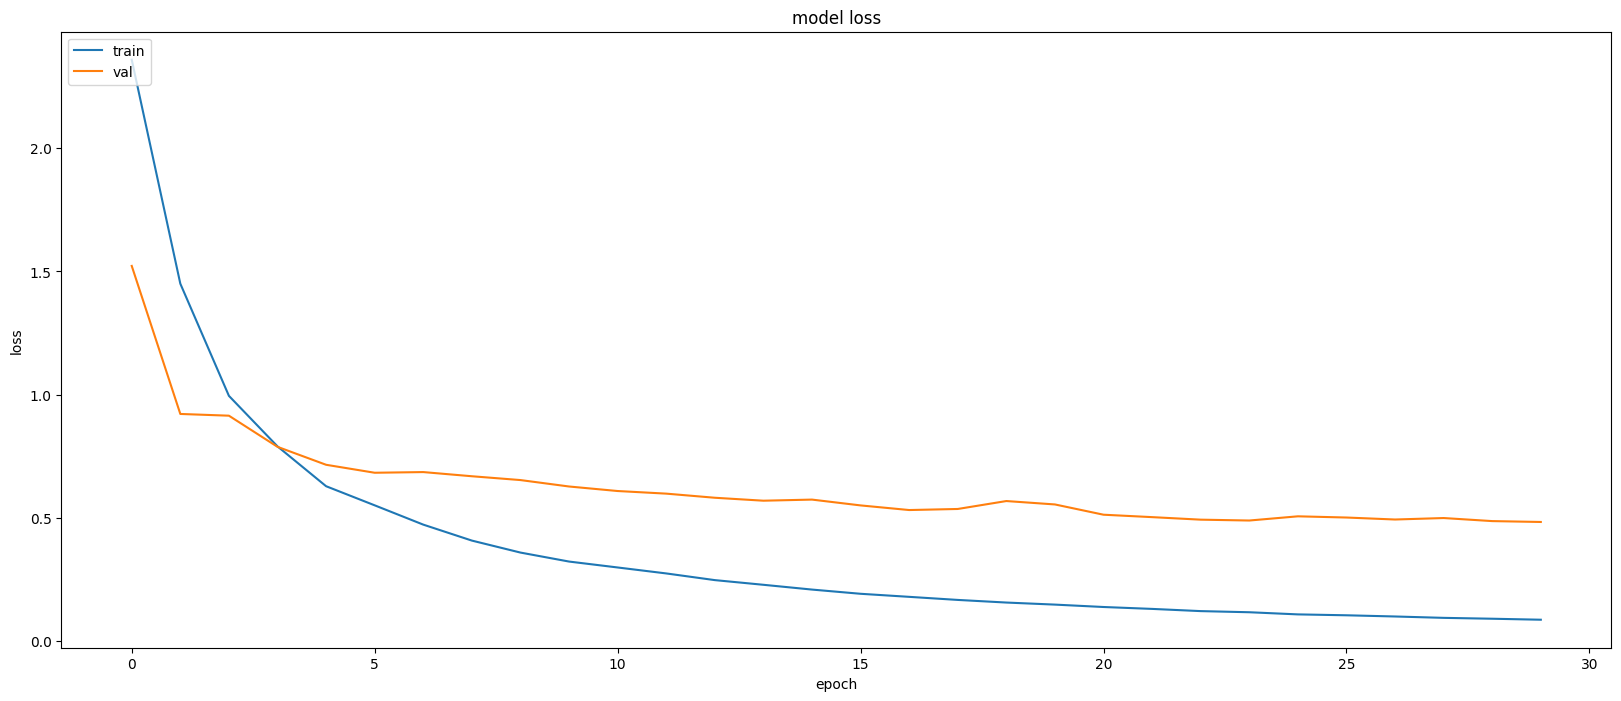

In [14]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

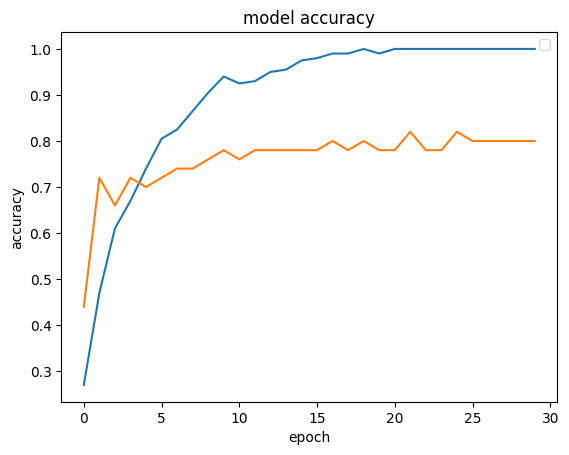

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [16]:
loss, accuracy = model.evaluate(train)

7/7 [==============================] - 40s 5s/step - loss: 0.0819 - accuracy: 1.0000


In [17]:
print(f"Accuracy is: {round(accuracy*100,2)}%")

Accuracy is: 100.0%


In [22]:
from tensorflow.keras.preprocessing.image import load_img
fpath= r"C:\Users\Gamer\Downloads\sal.jpg"
img_size = 224
batch_size = 32

image_path = fpath
single_image= load_img(image_path, target_size=(img_size, img_size))
single_image_array = tf.keras.preprocessing.image.img_to_array(single_image)
test= tf.expand_dims(single_image_array, 0)
print("Train shape:", test.shape)



Train shape: (1, 224, 224, 3)


In [23]:
a=int(np.argmax(model.predict(test), axis=1))
print(class_names[a])

1/1 [==============================] - 0s 361ms/step
salman_khan


In [24]:
model.save(r'C:\Users\Gamer\Downloads\Actors_model.h5')